<a href="https://colab.research.google.com/github/amitpanthi/Twitter-Sentiment-Analysis/blob/main/Tweet_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis of Tweets based on GloVe embeddings

This notebook demonstrates the application of Recurrent Neural Networks in a classification task.

We will be trying to get the sentiment of a given tweet, where the data was taken from a [Kaggle Dataset](https://www.kaggle.com/kazanova/sentiment140). This is a fairly challenging problem, with many applications in real life.

This problem can be expanded (with an appropriate dataset) to make spam detectors, bullying detector, and so on. The same model can be fit almost anywhere, where the underlying problem deals with extracting the sentiment out of a statement.

We are using a LSTM along with dropouts, after the data has undergone through some pre-processing.

Before proceeding, at the top menu of this colab notebook, Select Runtime-->change runtime type--->GPU. The code is GPU friendly, and will run seamlessly on a CPU, as well as cuda.

## Loading the dataset

The dataset used in this problem is [this](https://www.kaggle.com/kazanova/sentiment140), where we have 1.6 million tweets with 6 features: target, ids, date, flag, user and text. According to the dataset, these fields are defined as:<br>
<ol>
<li>target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)</li>
<li>ids: The id of the tweet (2087)</li>
<li>date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)</li>
<li>flag: The query (lyx). If there is no query, then this value is NO_QUERY.</li>
<li>user: the user that tweeted (robotickilldozr)</li>
<li>text: the text of the tweet (Lyx is cool)</li>
</ol>

The dataset is comprised in a single csv - "training.1600000.processed.noemoticon.csv".<br>

In [ ]:
from google.colab import files

files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kazanova/sentiment140

 90% 73.0M/80.9M [00:02<00:00, 26.6MB/s]
100% 80.9M/80.9M [00:02<00:00, 32.4MB/s]


In [ ]:
!mkdir dataset
!unzip sentiment140.zip -d dataset/

Archive:  sentiment140.zip
  inflating: dataset/training.1600000.processed.noemoticon.csv  


## Preprocessing

Out of the 6 input features, only 2 are relevant for our problem - target and text. We can discard rest of the features. Also, we are using torchtext to build the dataset, and because of how torchtext works, we will need to split our dataset into train.csv and test.csv files.<br>

This splitting is done in this section.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
fpath = "dataset/training.1600000.processed.noemoticon.csv"
col_names = ["target", "id", "date", "flag", "user", "tweet"]
tweets_df = pd.read_csv(fpath, encoding='latin', names=col_names)

In [ ]:
tweets_df.head()

,target,id,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
tweets_df["target"] = tweets_df["target"].replace(4, 1)

In [ ]:
train, test = train_test_split(tweets_df, test_size=0.1)

In [ ]:
train["target"].value_counts()

1    720046
0    719954
Name: target, dtype: int64

In [ ]:
train.to_csv("dataset/train.csv", header=True)
test.to_csv("dataset/test.csv", header=True)

## Making the dataset

After splitting the data into train and test csv's, we need to make a dataset that is usable by PyTorch. The whole process is done in this section.

In [ ]:
!pip install -U torchtext==0.8.0

     |████████████████████████████████| 7.0MB 10.1MB/s 
  Found existing installation: torchtext 0.9.1
    Uninstalling torchtext-0.9.1:
      Successfully uninstalled torchtext-0.9.1


We are using RegexpTokenizer here, which tokenizes based on an input regex patter. This is used to remove punctuations while tokenizing. We decided against the use of stopwords, since nltk's stopwords include words like "not", "shouldn't", etc, which are important in sentences where the negative sentiment isn't directly implied. 

In [ ]:
import torch
from torchtext.data import Field, TabularDataset, BucketIterator

import nltk
from nltk import RegexpTokenizer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def get_tokens(tweet):
    # tokenize, and remove punctuations
    tweet = tweet.lower()
    tokenizer = RegexpTokenizer(r"\w+")
    tokens = tokenizer.tokenize(tweet)
    return tokens

We use torchtext's Fields to convert data into a dtype that can be understood by torchtext. According to torchtext's documentation:<br><br>
*Field class models common text processing datatypes that can be represented by tensors. It holds a Vocab object that defines the set of possible values for elements of the field and their corresponding numerical representations. The Field object also holds other parameters relating to how a datatype should be numericalized, such as a tokenization method and the kind of Tensor that should be produced.*

We use our get_tokens() function defined earlier for preprocessing. Also, we convert all of our text to lowercase, since all GloVe embeddings are lowercase.

In [ ]:
tweet = Field(sequential=True, use_vocab=True, tokenize=get_tokens, lower=True)
target = Field(sequential=False, use_vocab=False)

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


After defining the fields we care about, we use a TabularDataset to convert our csv files into a Dataset object, which can be later used for training.<br>

The fields dictionary provides a mapping which helps our tabular dataset understand which column in the csv corresponds to which field. The mapping is:
"column name": ("name of the variable for that field", field name).<br>

For example, "tweet": ("t", tweet) implies that for a column named "tweet" in our input csv files, map it to the tweet Field. Also, for any batch made from this dataset, we can access that batch's tweet as
tweet = batch.t 

In [ ]:
fields = {"tweet": ("tweet", tweet), "target": ("target", target)}

In [ ]:
train_data, test_data = TabularDataset.splits(
                        path = "dataset",
                        train = "train.csv",
                        test = "test.csv",
                        format = "csv",
                        fields = fields
                        )

/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:52: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


Then, we build our field's vocabulary according to GloVe embeddings. The embeddings we are using is 'glove.twitter.27B.50d'. The embeddings are trained on 27 billion tokens, and have a dimension of 50. <br>

Also, we set min_freq to 10, which means that the minimum frequency for a word to appear in our vocabulary is 10. This is done because we get a lot of stray unique url's that appear only a couple of times in our post-processed dataset, and this helps eliminate those from our dataset.

In [ ]:
tweet.build_vocab(train_data, 
                  max_size=50000, 
                  min_freq=10, 
                  vectors='glove.twitter.27B.50d')

BucketIterator helps us split our data into batches, where each input sentence is padded to match the length of the longest string. The batches generated can then be plugged directly onto our Neural Network model for further training.

In [ ]:
train_iter, test_iter = BucketIterator.splits(
                            (train_data, test_data),
                            batch_size = 64,
                            sort_key = lambda x : len(x.tweet),
                            sort_within_batch = False,
                            device = device)

/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


## Defining a NN Architecture

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim

Our Neural Network architecture consists of an embedding layer, followed by a LSTM, followed by 2 Dense Layers.

We plug in the padding token used in our vocab into the padding_idx parameter of Embedding. This ensures that while training the Embedding layer, the embeddings of padding token stay the same.

We've also added a Dropout of 0.5 to our LSTM layers, in order to make the whole architecture more robust to unseen data.

We are not using a sigmoid in the final layer, since torch's BCEWithLogitsLoss applies a sigmoid to the final output of our layer, and makes the whole model more numerically stable.

In [ ]:
class SentimentPredictor(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_lstm_layers, pad_token):
        super(SentimentPredictor, self).__init__()
        
        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size, padding_idx=pad_token)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_lstm_layers, dropout=0.5)
        self.dense1 = nn.Linear(hidden_size, 64)
        self.dense2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = torch.relu(self.dense1(x[-1, :, :])) # get hidden size first
        x = self.dense2(x)

        return x

In [ ]:
# Define Hyperparameters
input_size = len(tweet.vocab)
embedding_size = 50 # gloVe specification
hidden_size = 512
num_layers = 1
pad_token = tweet.vocab.stoi[tweet.pad_token]

# Instantiate model object
model = SentimentPredictor(input_size, embedding_size, hidden_size, num_layers, pad_token).to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


After initializing our model, we load the weights of GloVe embeddings onto our model's embedding layers.

In [ ]:
# Load gloVe weights onto our embedding layer's weights
glove_embeddings = tweet.vocab.vectors
model.embedding.weight.data.copy_(glove_embeddings)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0431,  0.5039,  0.2709,  ..., -0.2238, -0.6603, -0.7065],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.7224, -0.3856, -0.5189,  ...,  0.2659,  0.0056, -0.6017]],
       device='cuda:0')

We are using BCEWithLogitsLoss as our loss criterion. This applies a sigmoid to the model's output, which will then be used to find out the Binary Cross-Entropy loss.

For our optimizer, we are using Adam, with default parameters, i.e., lr = 0.001, beta1 = 0.9, beta2 = 0.999

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())

We also define a function to find out the accuracy of our model, given model's predictions and the labels.

In [ ]:
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
# Training loop
from tqdm import tqdm
fin_ev_loss = []
fin_ev_acc = []
fin_tr_loss = []
fin_tr_acc = []
num_epochs = 20

for epoch in range(num_epochs):
    epoch_loss = []
    acc = []
    eval_loss = []
    eval_acc = []

    for batch in train_iter:
        model.train()
        data = batch.tweet.to(device)
        targets = batch.target.to(device)

        # forward
        scores = model(data)
        loss = criterion(scores.squeeze(1), targets.type_as(scores))
        epoch_loss.append(loss.item())
        acc.append(binary_accuracy(scores.squeeze(1), targets.type_as(scores)).item())
        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent
        optimizer.step()
        
    fin_tr_loss.append(np.mean(epoch_loss))
    fin_tr_acc.append(np.mean(acc))

    with torch.no_grad():
        for batch in test_iter:
            model.eval()
            data = batch.tweet.to(device)
            targets = batch.target.to(device)

            scores = model(data)
            loss = criterion(scores.squeeze(1), targets.type_as(scores))
            eval_loss.append(loss.item())
            eval_acc.append(binary_accuracy(scores.squeeze(1), targets.type_as(scores)).item())

        fin_ev_loss.append(np.mean(eval_loss))
        fin_ev_acc.append(np.mean(eval_acc))

    print(f"Epoch {epoch+1}: {np.mean(acc):.4f} Accuracy, {np.mean(epoch_loss):.4f} Epoch Loss \| Evaluation: Accuracy = {np.mean(eval_acc):.4f}, Loss = {np.mean(eval_loss):.4f}")

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch 1: 0.8068 Accuracy, 0.4095 Epoch Loss \| Evaluation: Accuracy = 0.8288, Loss = 0.3875
Epoch 2: 0.8445 Accuracy, 0.3505 Epoch Loss \| Evaluation: Accuracy = 0.8365, Loss = 0.3685
Epoch 3: 0.8586 Accuracy, 0.3237 Epoch Loss \| Evaluation: Accuracy = 0.8363, Loss = 0.3715
Epoch 4: 0.8720 Accuracy, 0.2974 Epoch Loss \| Evaluation: Accuracy = 0.8321, Loss = 0.3826
Epoch 5: 0.8862 Accuracy, 0.2693 Epoch Loss \| Evaluation: Accuracy = 0.8305, Loss = 0.4055
Epoch 6: 0.8990 Accuracy, 0.2430 Epoch Loss \| Evaluation: Accuracy = 0.8255, Loss = 0.4228
Epoch 7: 0.9090 Accuracy, 0.2214 Epoch Loss \| Evaluation: Accuracy = 0.8221, Loss = 0.4323
Epoch 8: 0.9177 Accuracy, 0.2032 Epoch Loss \| Evaluation: Accuracy = 0.8185, Loss = 0.4472
Epoch 9: 0.9235 Accuracy, 0.1893 Epoch Loss \| Evaluation: Accuracy = 0.8189, Loss = 0.4658
Epoch 10: 0.9286 Accuracy, 0.1779 Epoch Loss \| Evaluation: Accuracy = 0.8172, Loss = 0.4855
Epoch 11: 0.9322 Accuracy, 0.1699 Epoch Loss \| Evaluation: Accuracy = 0.8155, 

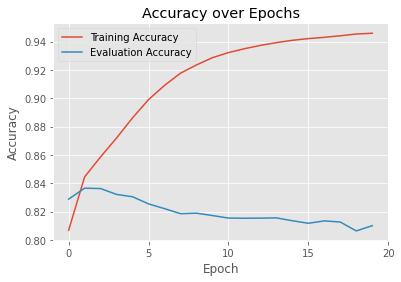

In [ ]:
# Plotting acc

plt.style.use("ggplot")

fig, ax = plt.subplots()

ax.plot(fin_tr_acc, label="Training Accuracy")
ax.plot(fin_ev_acc, label="Evaluation Accuracy") 
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy over Epochs")
ax.set_xticks(np.arange(0, 25, 5))
plt.legend()
plt.show()

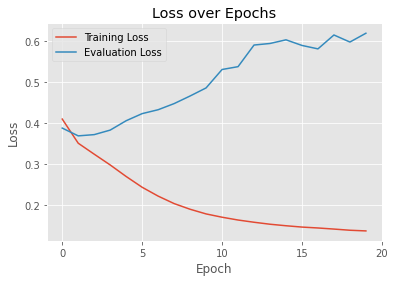

In [ ]:
# Plotting loss

fig, ax = plt.subplots()

ax.plot(fin_tr_loss, label="Training Loss")
ax.plot(fin_ev_loss, label="Evaluation Loss") 
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss over Epochs")
ax.set_xticks(np.arange(0, 25, 5))
plt.legend()
plt.show()

We can get the sentiment of a user input string using the get_sentiment function. In this function:
<ul>
<li>The input string is first converted into tokens, and numericalized according to our vocabulary dictionary (stoi).</li>
<li>These tokens are then converted into a Tensor.</li>
<li>After this, the tokens are finally transposed, in order to match the input requirement of our model.</li>

Finally, these transposed tokens are then used for getting a prediction.

If the prediction is greater than 0.5, we say that the overall sentiment associated with the input tweet is Positive, else Negative.

In [ ]:
def get_sentiment(tweet_str, model, stoi):
    model.eval()
    tokens = get_tokens(tweet_str)
    tweet_tokens = [stoi.get(token, 0) for token in tokens]
    tweet_tokens = torch.Tensor(tweet_tokens).long().to(device)
    tweet_tokens = torch.transpose(tweet_tokens.unsqueeze(0), 0, 1)

    output = model(tweet_tokens)
    output = torch.sigmoid(output).item()

    return f"Score: {output:.2f}, Positive" if output > 0.5 else f"Score: {output:.2f}, Negative"

## Saving Model

Here, we save the model for further inference. The "sentiment.pth" file saved can be loaded later to get a checkpoint. The loaded item is a dictionary, with the following keys:
<ul>
<li>model_params: State Dict of our trained model. This is a dictionary that stores the weights and other trained parameters. We can copy these weights onto a newly instantiated model (with the same architecture).</li>
<li>stoi: Our vocabulary's stoi dictionary. This dictionary contains pairs of (string, integer) mappings.</li>
<li>loss: A list containing the loss metrics of our trained model.</li>
<li>accuracy: A list containing the accuracy metrics of our trained model.</li>

In [ ]:
# Saving all the hyperparameters into a dict

hparams = dict()
hparams["input_size"] = len(tweet.vocab)
hparams["embedding_size"] = 50 # gloVe specification
hparams["hidden_size"] = 512
hparams["num_layers"] = 2
hparams["pad_token"] = tweet.vocab.stoi[tweet.pad_token]

In [ ]:
torch.save({"model_params":model.state_dict(), "stoi":dict(tweet.vocab.stoi), "loss":fin_loss, "accuracy":fin_acc, "hparams":hparams}, "sentiment.pth")

In [ ]:
# Add the param map_location=torch.device('cpu') if you're running this on a cpu
checkpoint = torch.load("sentiment.pth")

In [ ]:
hparams = checkpoint["hparams"]
input_size = hparams["input_size"]
embedding_size = hparams["embedding_size"]
hidden_size = hparams["hidden_size"]
num_layers = hparams["num_layers"]
pad_token = hparams["pad_token"]

net = SentimentPredictor(input_size, embedding_size, hidden_size, num_layers, pad_token).to(device)

In [ ]:
net.load_state_dict(checkpoint["model_params"])

<All keys matched successfully>

In [ ]:
get_sentiment("this is a fun movie to watch", net, checkpoint["stoi"])

'Score: 0.82, Positive'

In [ ]:
get_sentiment("This was not a good movie", net, checkpoint["stoi"])

'Score: 0.09, Negative'